## Install and import dependencies

In [ ]:
!pip install git+https://github.com/haotian-liu/LLaVA.git@786aa6a19ea10edc6f574ad2e16276974e9aaa3a

  Cloning https://github.com/haotian-liu/LLaVA.git (to revision 786aa6a19ea10edc6f574ad2e16276974e9aaa3a) to /tmp/pip-req-build-d098wugh
  Running command git clone --filter=blob:none --quiet https://github.com/haotian-liu/LLaVA.git /tmp/pip-req-build-d098wugh
  Running command git rev-parse -q --verify 'sha^786aa6a19ea10edc6f574ad2e16276974e9aaa3a'
  Running command git fetch -q https://github.com/haotian-liu/LLaVA.git 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Running command git checkout -q 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Resolved https://github.com/haotian-liu/LLaVA.git to commit 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 103

In [ ]:
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
import torch
from PIL import Image
import requests
from io import BytesIO
from typing import Union
import numpy as np

## Define the chatbot class


In [ ]:
class LLaVAChatBot:
    def __init__(self,
                 model_path: str = 'liuhaotian/llava-v1.5-13b',
                 device_map: str = 'auto',
                 load_in_8_bit: bool = True,
                 **quant_kwargs) -> None:
        self.model = None
        self.tokenizer = None
        self.image_processor = None
        self.conv = None
        self.conv_img = None
        self.img_tensor = None
        self.roles = None
        self.stop_key = None
        self.load_models(model_path,
                         device_map=device_map,
                         load_in_8_bit=load_in_8_bit,
                         **quant_kwargs)

    def load_models(self, model_path: str,
                    device_map: str,
                    load_in_8_bit: bool,
                    **quant_kwargs) -> None:
        quant_cfg = BitsAndBytesConfig(**quant_kwargs)
        self.model = LlavaLlamaForCausalLM.from_pretrained(model_path,
                                                           low_cpu_mem_usage=True,
                                                           device_map=device_map,
                                                           load_in_8bit=load_in_8_bit,
                                                           quantization_config=quant_cfg)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path,
                                                       use_fast=False)
        vision_tower = self.model.get_vision_tower()
        vision_tower.load_model()
        vision_tower.to(device='cuda')
        self.image_processor = vision_tower.image_processor  # Check this line!
        disable_torch_init()

    def setup_image(self, img: Union[str, np.ndarray]) -> None:
        """Load and process the image from either a file path, URL, or numpy array."""
        if isinstance(img, str):
            if img.startswith('http') or img.startswith('https'):
                response = requests.get(img)
                self.conv_img = Image.open(BytesIO(response.content)).convert('RGB')
            else:
                self.conv_img = Image.open(img).convert('RGB')
        elif isinstance(img, np.ndarray):

            if len(img.shape) == 2:
                img = np.stack((img,)*3, axis=-1)
            elif len(img.shape) == 3 and img.shape[2] == 1:
                img = np.repeat(img, 3, axis=2)
            elif len(img.shape) == 3 and img.shape[2] == 4:
                img = img[:,:,:3]

            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)

            try:
                self.conv_img = Image.fromarray(img, 'RGB')
            except Exception as e:
                print(f"Error converting numpy array to PIL Image: {str(e)}")
                raise
        else:
            raise ValueError("Input must be either a string (file path or URL) or a numpy array.")


        self.img_tensor = self.image_processor.preprocess(self.conv_img,
                                                          return_tensors='pt'
                                                          )['pixel_values'].half().cuda()

    def generate_answer(self, **kwargs) -> str:
        """Generate an answer from the current conversation."""
        raw_prompt = self.conv.get_prompt()
        input_ids = tokenizer_image_token(raw_prompt,
                                          self.tokenizer,
                                          IMAGE_TOKEN_INDEX,
                                          return_tensors='pt').unsqueeze(0).cuda()
        stopping = KeywordsStoppingCriteria([self.stop_key],
                                            self.tokenizer,
                                            input_ids)
        with torch.inference_mode():
            output_ids = self.model.generate(input_ids,
                                             images=self.img_tensor,
                                             stopping_criteria=[stopping],
                                             **kwargs)
        outputs = self.tokenizer.decode(
            output_ids[0, input_ids.shape[1]:]
        ).strip()
        self.conv.messages[-1][-1] = outputs

        return outputs.rsplit('</s>', 1)[0]

    def get_conv_text(self) -> str:
        """Return full conversation text."""
        return self.conv.get_prompt()

    def start_new_chat(self,
                       img: Union[str, np.ndarray],
                       prompt: str = None,
                       do_sample=False,
                       temperature=0.05,
                       max_new_tokens=32,
                       use_cache=True,
                       **kwargs) -> str:
        """Start a new chat with a new image."""
        conv_mode = "v1"
        self.setup_image(img)
        self.conv = conv_templates[conv_mode].copy()
        self.roles = self.conv.roles

        prompt_template = """
        """

        if prompt is None:
            first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                           DEFAULT_IM_END_TOKEN + '\n' + prompt_template)
        else:
            first_input = (DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN +
                           DEFAULT_IM_END_TOKEN + '\n' + prompt)

        self.conv.append_message(self.roles[0], first_input)
        self.conv.append_message(self.roles[1], None)
        if self.conv.sep_style == SeparatorStyle.TWO:
            self.stop_key = self.conv.sep2
        else:
            self.stop_key = self.conv.sep
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

    def continue_chat(self,
                      prompt: str,
                      do_sample=True,
                      temperature=0.05,
                      max_new_tokens=512,
                      use_cache=True,
                      **kwargs) -> str:
        """Continue the existing chat."""
        if self.conv is None:
            raise RuntimeError("No existing conversation found. Start a new"
                               "conversation using the `start_new_chat` method.")
        self.conv.append_message(self.roles[0], prompt)
        self.conv.append_message(self.roles[1], None)
        answer = self.generate_answer(do_sample=do_sample,
                                      temperature=temperature,
                                      max_new_tokens=max_new_tokens,
                                      use_cache=use_cache,
                                      **kwargs)
        return answer

## Setup the model

Download the model and set up the chatbot. It may take several minutes.

In [ ]:
chatbot = LLaVAChatBot(load_in_8bit=True,
                       bnb_8bit_compute_dtype=torch.float16,
                       bnb_8bit_use_double_quant=True,
                       bnb_8bit_quant_type='nf8')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/6.24G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download kay_labels.npy completed!
Download kay_labels_val.npy completed!
Download kay_images.npz completed!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

stimuli = dat['stimuli']
responses = dat['responses']
roi = dat['roi']
roi_names = dat['roi_names']
stimuli_test = dat['stimuli_test']
responses_test = dat['responses_test']
print(dat.keys())
X_train, X_test = stimuli, stimuli_test,

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


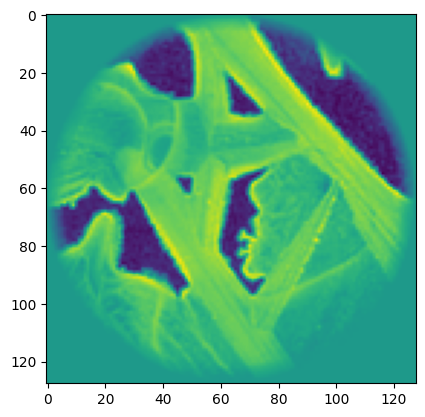

In [ ]:
plt.imshow(X_train[47])

In [ ]:
FT_Labels = [1,0,1,1,0,1,1,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,1,0,0,1]

In [ ]:
len(FT_Labels)

50

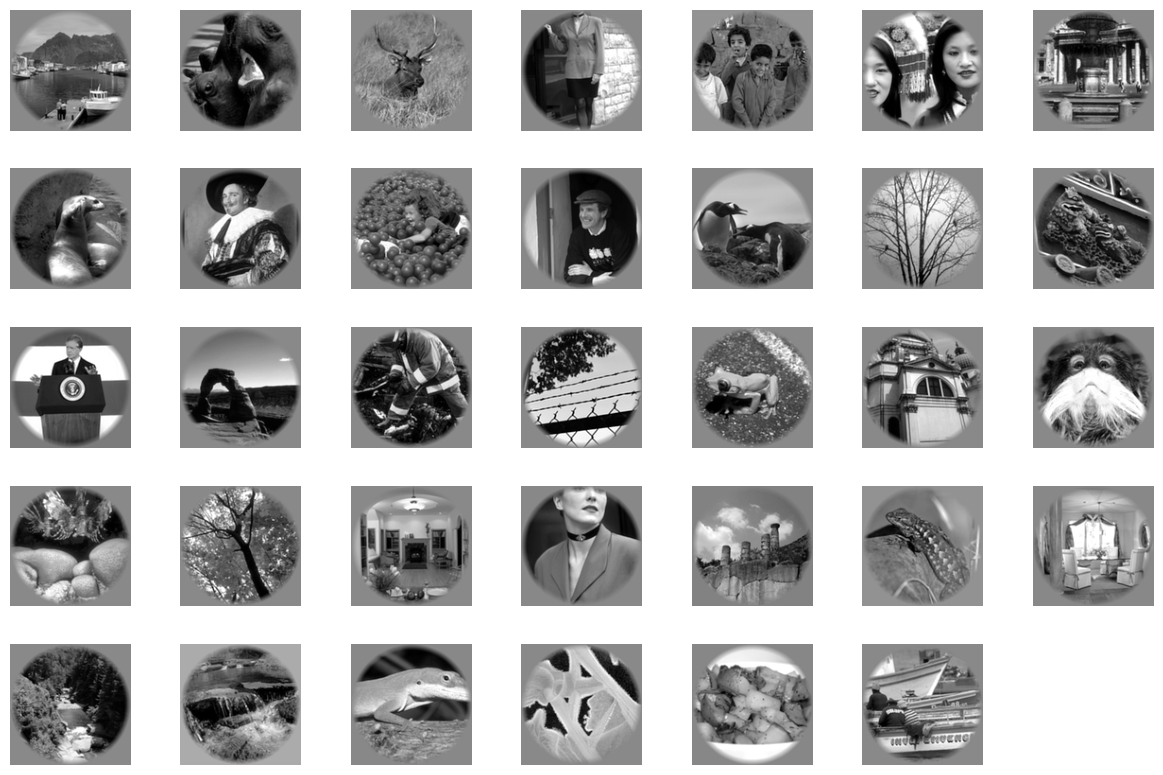

In [ ]:
n_rows = 5
n_cols = 7
n_images = 34
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
fig.tight_layout(pad=0.5)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each image
for i, x in enumerate(X_train[16:50]):
    if i < n_rows * n_cols:  # Ensure we don't exceed the number of subplots
        ax = axes[i]
        ax.imshow(x, cmap='gray')  # Adjust cmap if your images are not grayscale
        ax.axis('off')  # Turn off axis labels

# Remove any unused subplots
for i in range(n_images, n_rows * n_cols):
    fig.delaxes(axes[i])

plt.show()

Image 1: Chatbot - animate, FT_Label - animate
Image 2: Chatbot - inanimate, FT_Label - inanimate
Image 3: Chatbot - animate, FT_Label - animate
Image 4: Chatbot - inanimate, FT_Label - animate
Image 5: Chatbot - inanimate, FT_Label - inanimate
Image 6: Chatbot - inanimate, FT_Label - animate
Image 7: Chatbot - inanimate, FT_Label - animate
Image 8: Chatbot - animate, FT_Label - animate
Image 9: Chatbot - animate, FT_Label - animate
Image 10: Chatbot - inanimate, FT_Label - inanimate
Image 11: Chatbot - inanimate, FT_Label - inanimate
Image 12: Chatbot - inanimate, FT_Label - inanimate
Image 13: Chatbot - inanimate, FT_Label - inanimate
Image 14: Chatbot - animate, FT_Label - animate
Image 15: Chatbot - inanimate, FT_Label - inanimate
Image 16: Chatbot - inanimate, FT_Label - inanimate
Image 17: Chatbot - inanimate, FT_Label - inanimate
Image 18: Chatbot - animate, FT_Label - animate
Image 19: Chatbot - animate, FT_Label - animate
Image 20: Chatbot - animate, FT_Label - animate
Image 2

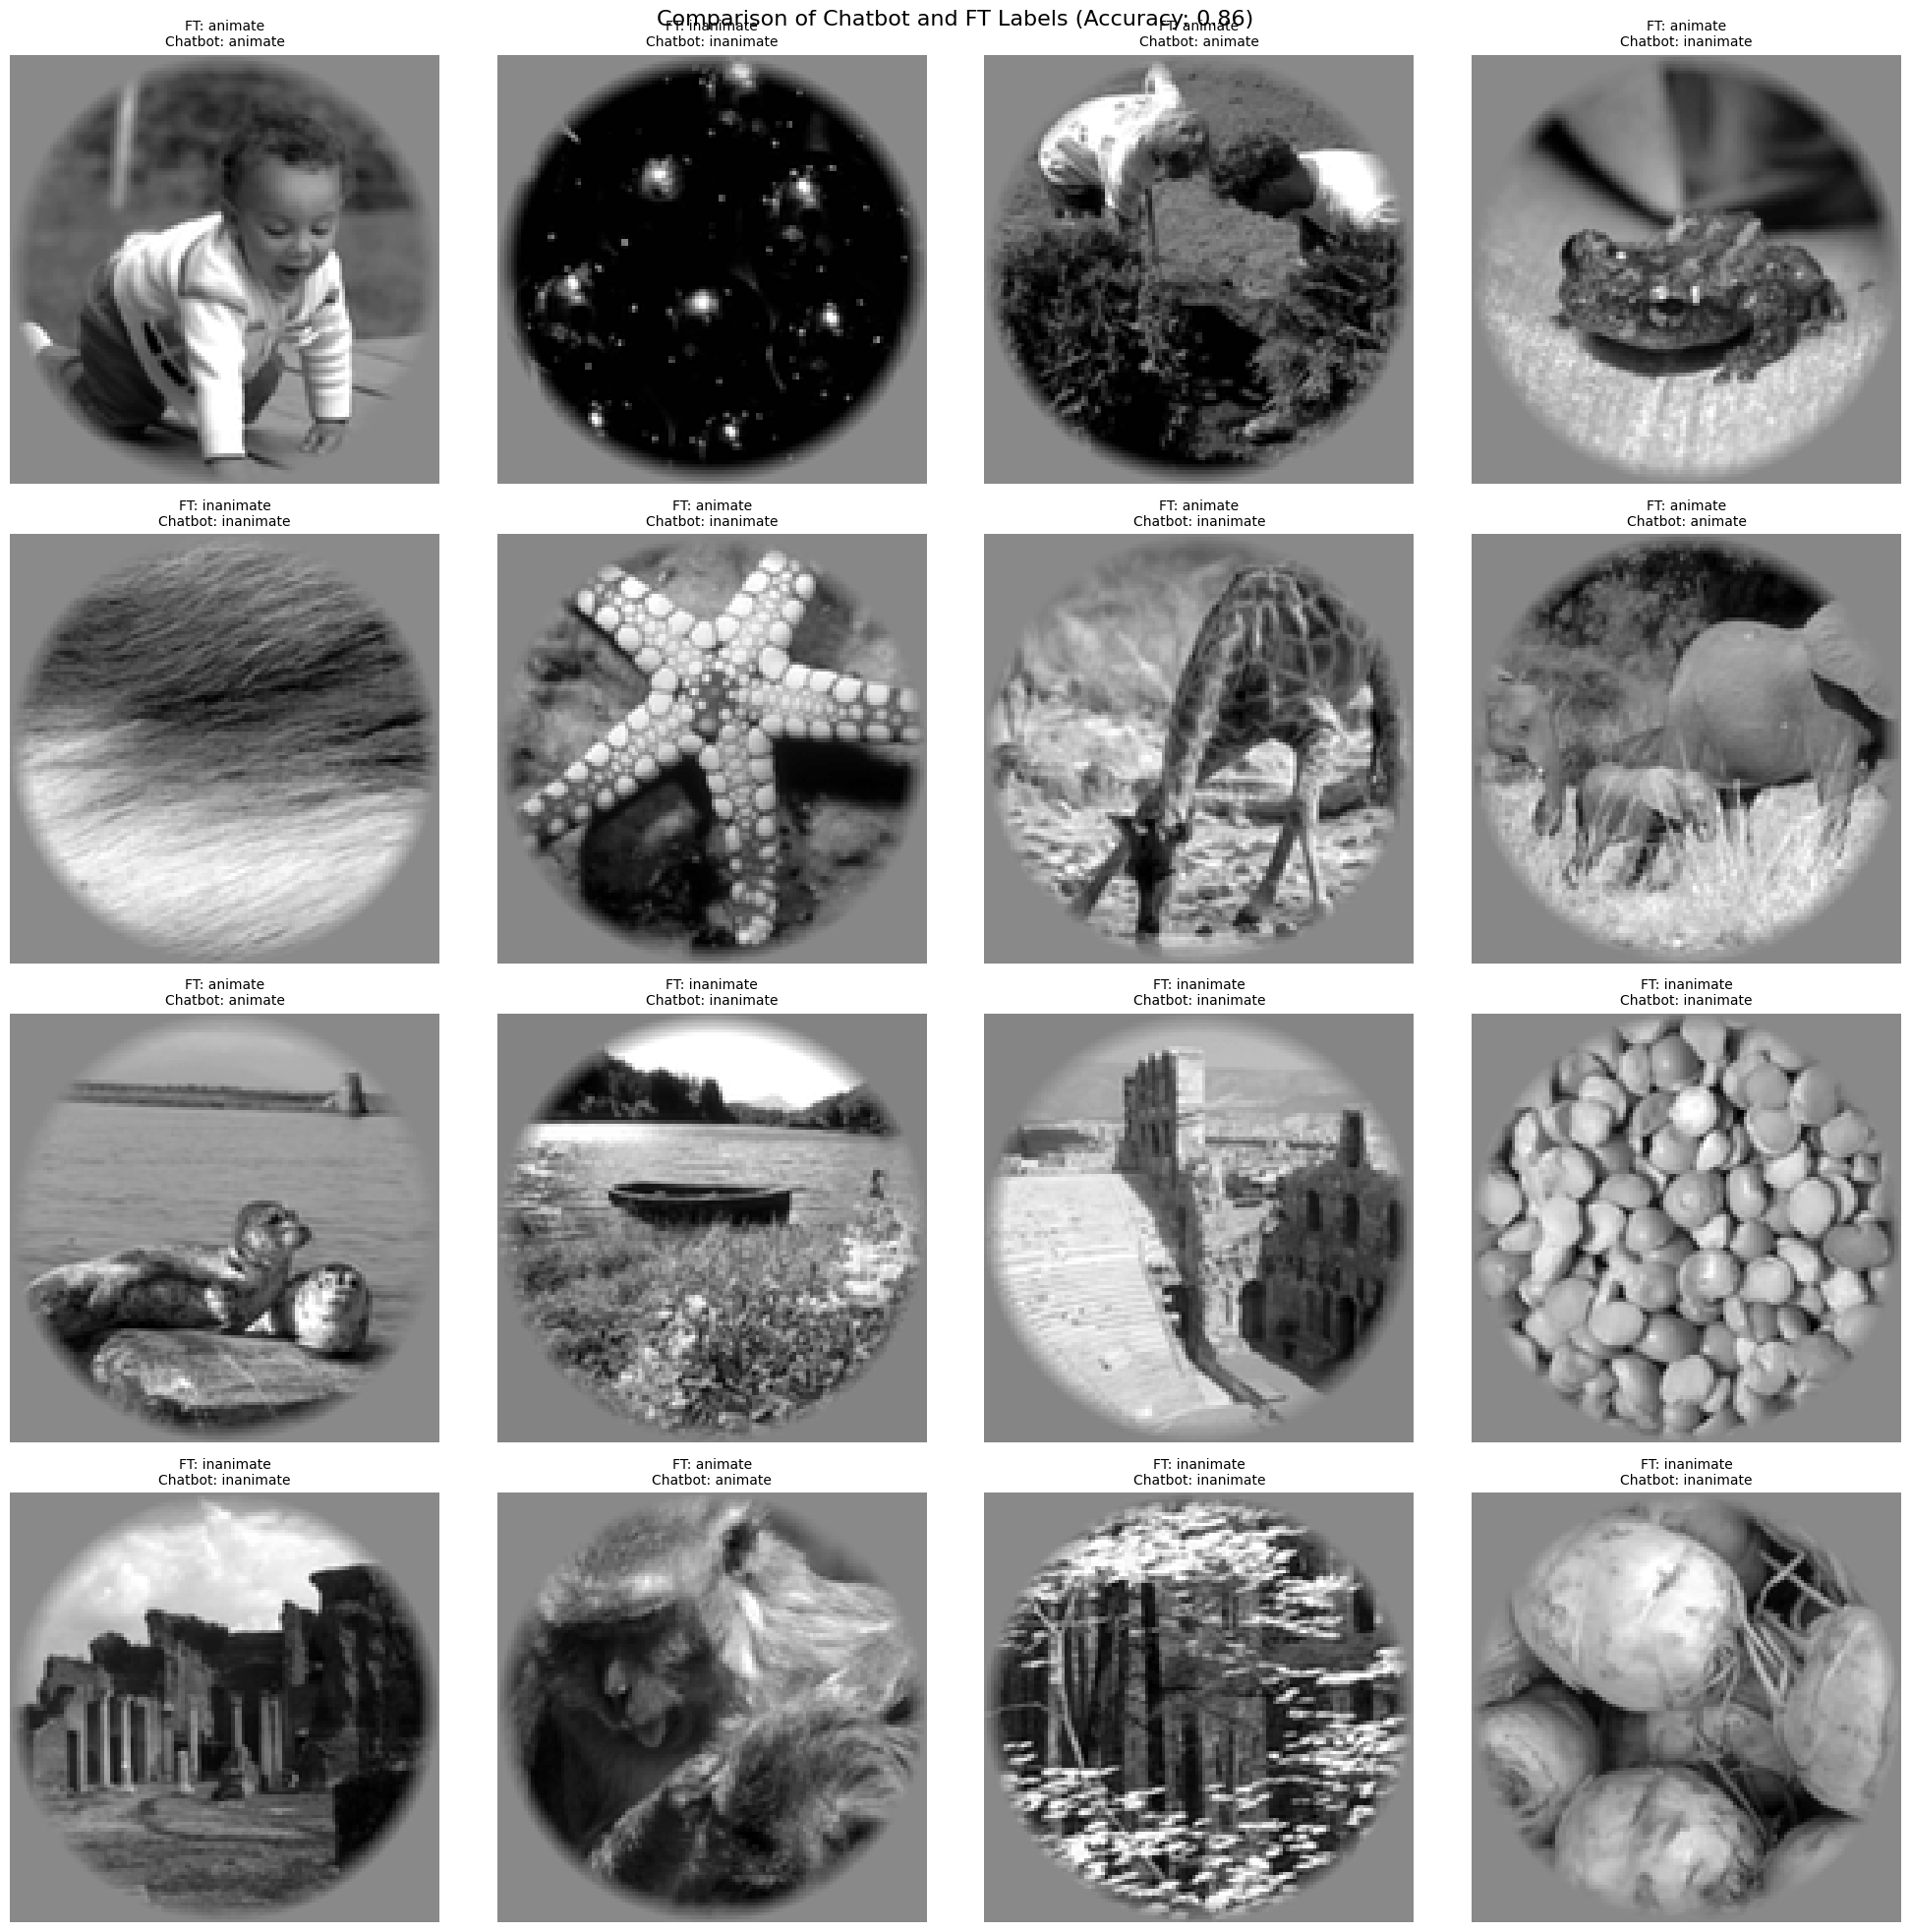


Labels for the first 6 images:
Image 1: Chatbot - animate, FT_Label - animate
Image 2: Chatbot - inanimate, FT_Label - inanimate
Image 3: Chatbot - animate, FT_Label - animate
Image 4: Chatbot - inanimate, FT_Label - animate
Image 5: Chatbot - inanimate, FT_Label - inanimate
Image 6: Chatbot - inanimate, FT_Label - animate
Image 7: Chatbot - inanimate, FT_Label - animate
Image 8: Chatbot - animate, FT_Label - animate
Image 9: Chatbot - animate, FT_Label - animate
Image 10: Chatbot - inanimate, FT_Label - inanimate
Image 11: Chatbot - inanimate, FT_Label - inanimate
Image 12: Chatbot - inanimate, FT_Label - inanimate
Image 13: Chatbot - inanimate, FT_Label - inanimate
Image 14: Chatbot - animate, FT_Label - animate
Image 15: Chatbot - inanimate, FT_Label - inanimate
Image 16: Chatbot - inanimate, FT_Label - inanimate
Image 17: Chatbot - inanimate, FT_Label - inanimate
Image 18: Chatbot - animate, FT_Label - animate
Image 19: Chatbot - animate, FT_Label - animate
Image 20: Chatbot - ani

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def label_and_compare_images(chatbot, X_train, FT_Labels, num_images):
    results = []
    for i in range(num_images):
        chatbot_ans = chatbot.start_new_chat(
            img=X_train[i],
            prompt=
    """Classify the main subject of the image as either "Animate" or "Inanimate".

Animate: Living beings (humans, animals, plants).
Inanimate: Non-living objects, scenes, or patterns.

The image has been preprocessed to highlight the central circular area.

Respond with a single word: "Animate" or "Inanimate".
        """
        ).strip().lower()
        ft_label = "animate" if FT_Labels[i] else "inanimate"

        results.append({
            'chatbot_label': chatbot_ans,
            'ft_label': ft_label,
            'image': X_train[i],
            'match': chatbot_ans == ft_label
        })

        print(f"Image {i+1}: Chatbot - {chatbot_ans}, FT_Label - {ft_label}")

    return results

results = label_and_compare_images(chatbot, X_train, FT_Labels, 50)

accuracy = sum(result['match'] for result in results) / len(results)
print(f"\nAccuracy: {accuracy:.2f}")

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle(f"Comparison of Chatbot and FT Labels (Accuracy: {accuracy:.2f})", fontsize=16)

for i, (result, ax) in enumerate(zip(results, axes.flat)):
    ax.imshow(result['image'], cmap='gray')
    ax.set_title(f"FT: {result['ft_label']}\nChatbot: {result['chatbot_label']}", fontsize=10)
    ax.axis('off')
    if result['match']:
        ax.set_facecolor('lightgreen')
    else:
        ax.set_facecolor('lightcoral')

plt.tight_layout()
plt.show()

print("\nLabels for the first 6 images:")
for i, result in enumerate(results):
    print(f"Image {i+1}: Chatbot - {result['chatbot_label']}, FT_Label - {result['ft_label']}")

print(f"\nAgreement between Chatbot and FT_Labels: {accuracy:.2f}")


Accuracy: 0.48

Classification Report:
              precision    recall  f1-score   support

   Inanimate       0.75      0.39      0.51        23
     Animate       0.63      0.89      0.74        27

    accuracy                           0.66        50
   macro avg       0.69      0.64      0.63        50
weighted avg       0.69      0.66      0.64        50



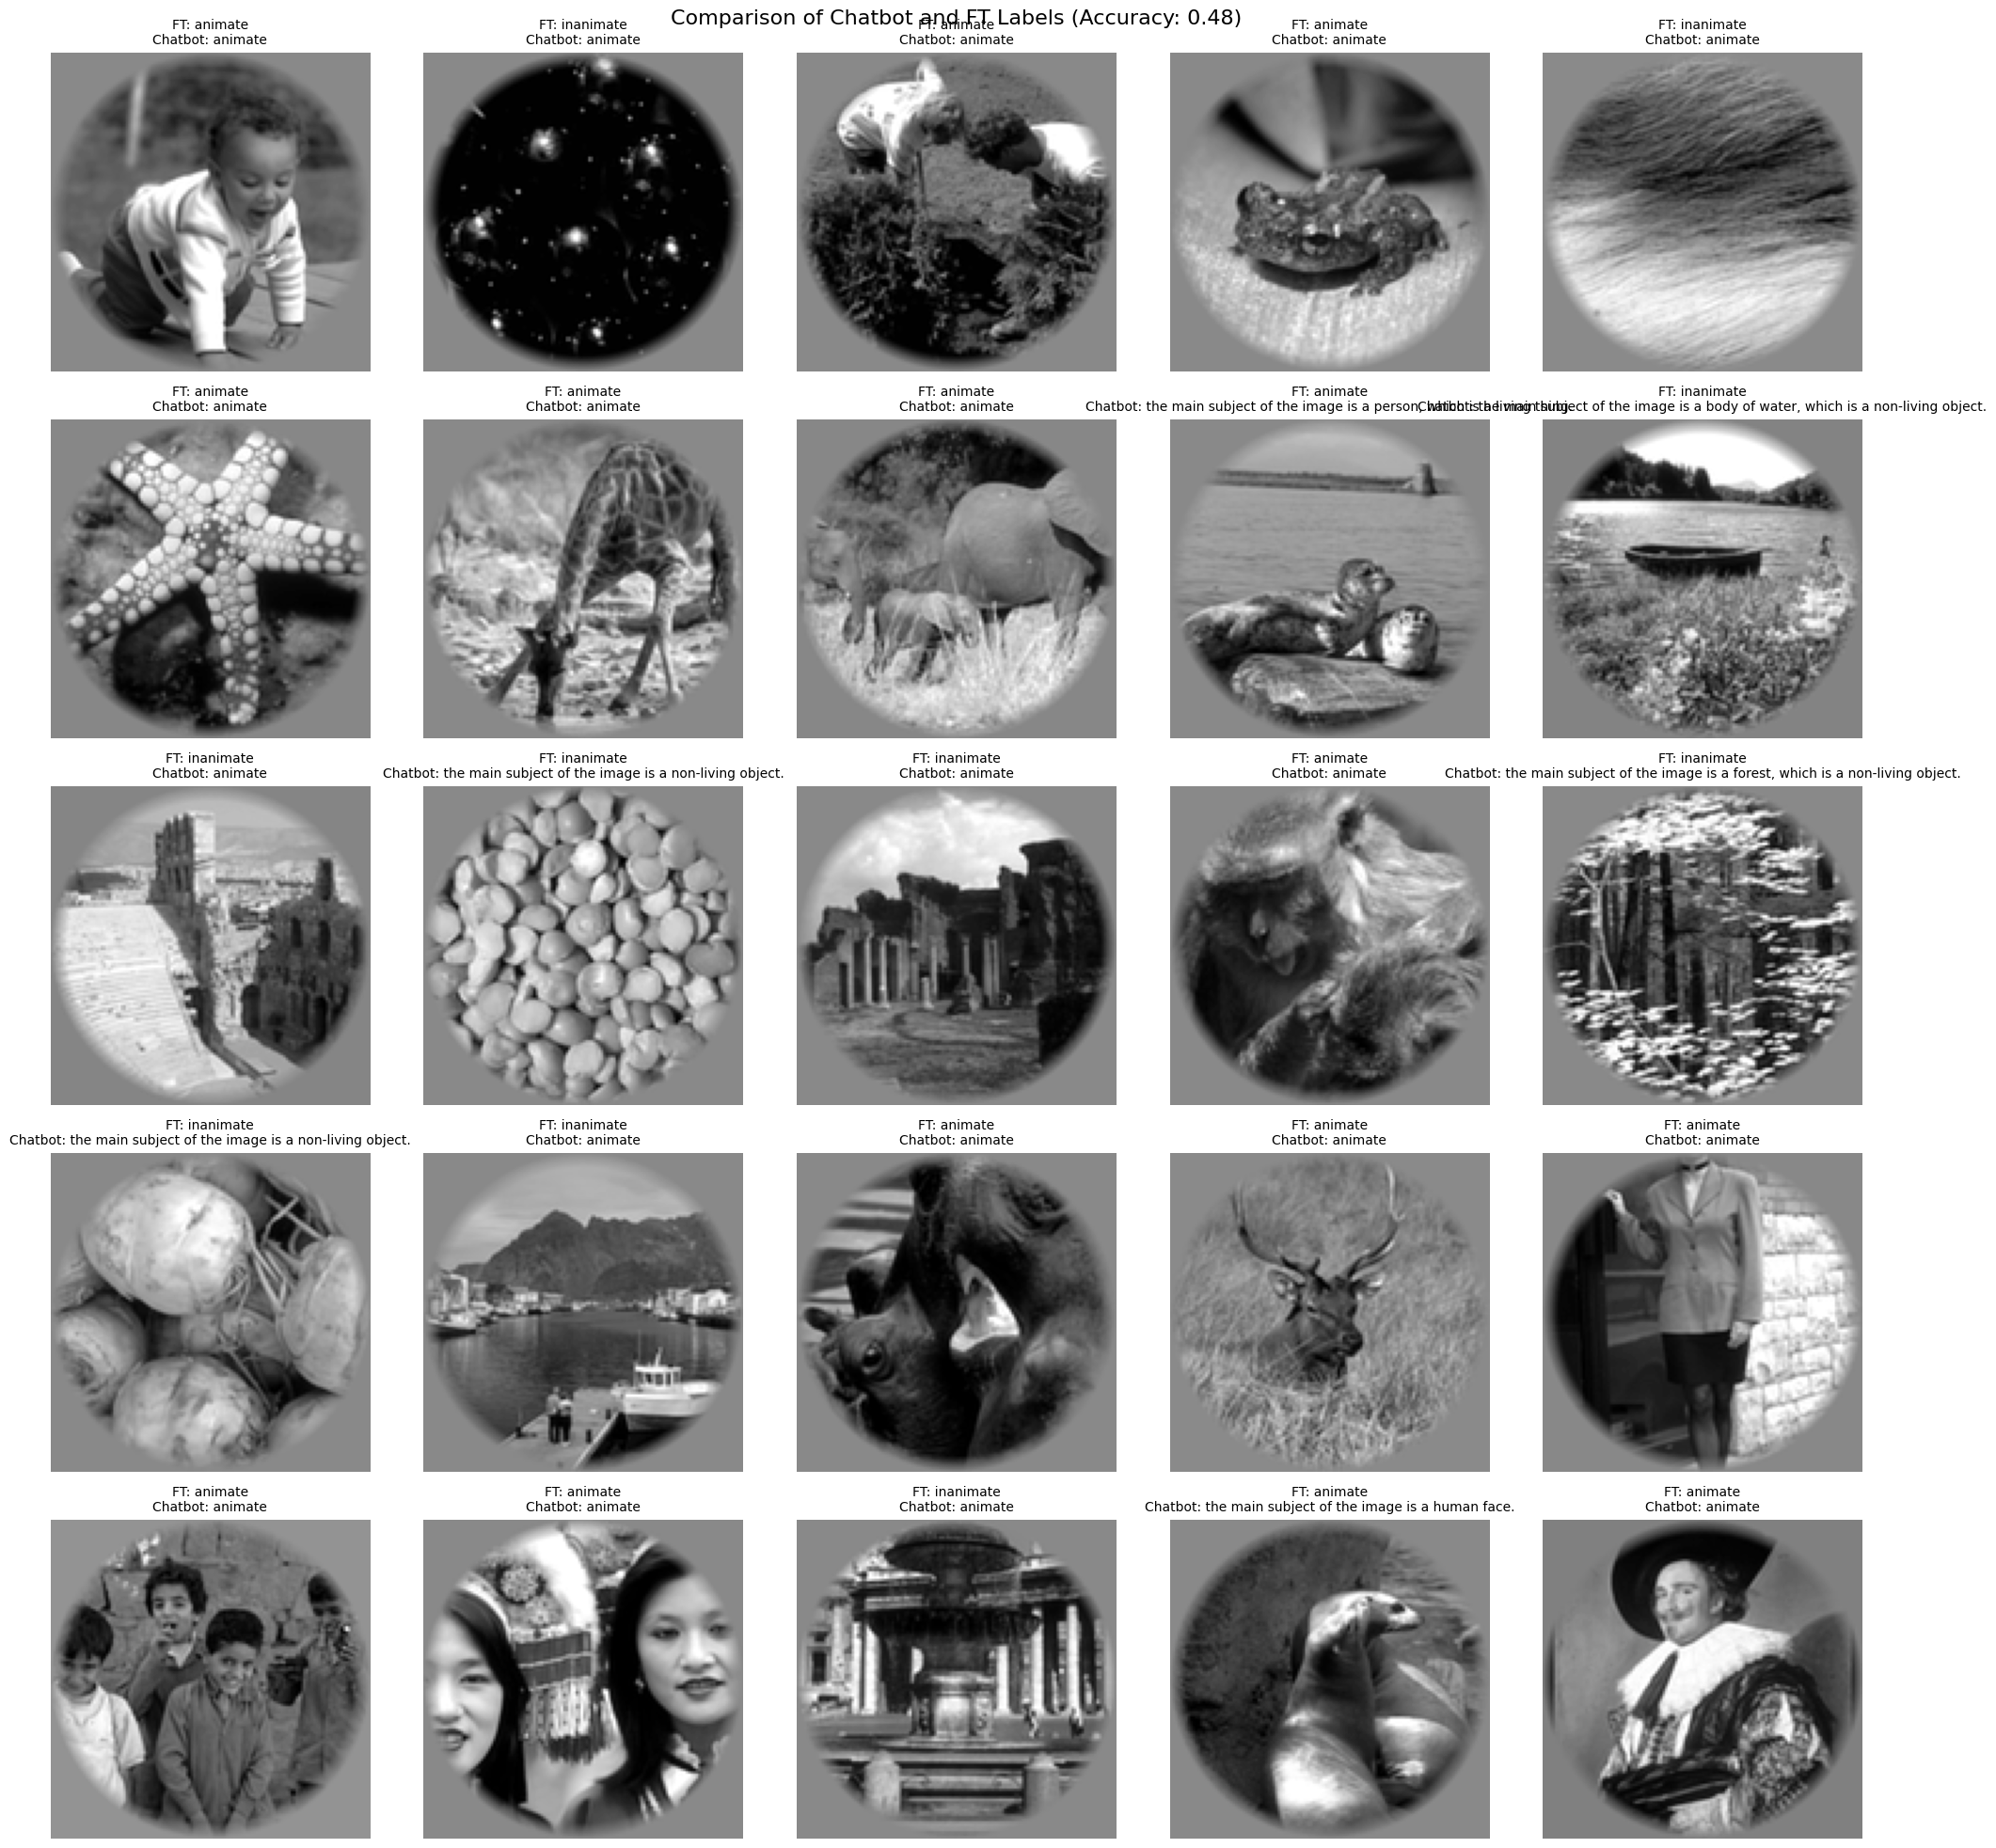

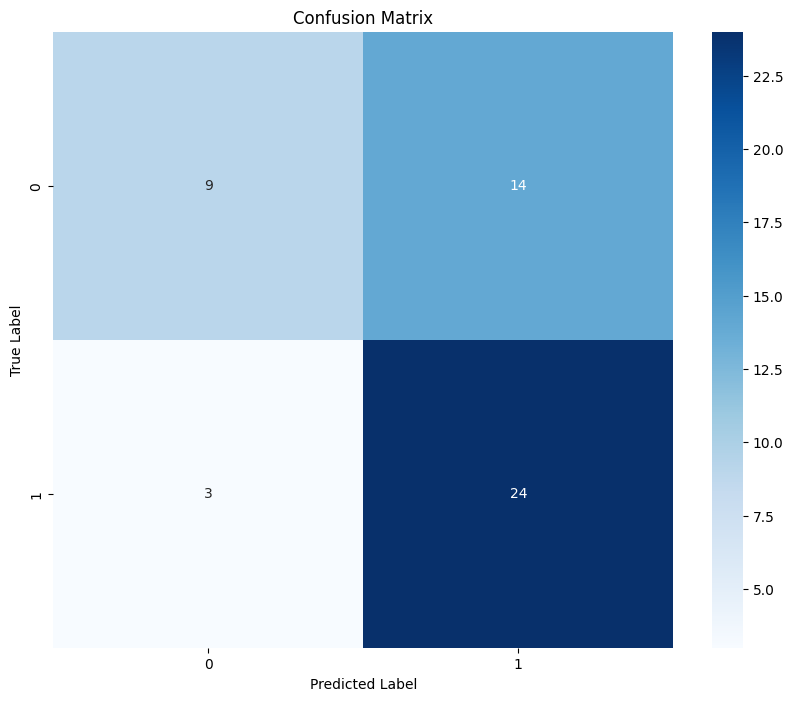

Total misclassifications: 26
Animate classified as Inanimate: 0
Inanimate classified as Animate: 14


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def label_and_compare_images(chatbot, X_train, FT_Labels, num_images):
    results = []
    for i in range(num_images):
        chatbot_ans = chatbot.start_new_chat(
            img=X_train[i],
            prompt=
    """Step 1: Describe the main subject of the image in one sentence.
Step 2: Is the main subject a living thing (human, animal, plant) or a non-living object?
Step 3: Based on step 2, classify as "Animate" or "Inanimate".
        """
        ).strip().lower()
        ft_label = "animate" if FT_Labels[i] else "inanimate"

        results.append({
            'chatbot_label': chatbot_ans,
            'ft_label': ft_label,
            'image': X_train[i],
            'match': chatbot_ans == ft_label
        })

    return results

def analyze_results(results):
    accuracy = sum(result['match'] for result in results) / len(results)

    y_true = [1 if result['ft_label'] == 'animate' else 0 for result in results]
    y_pred = [1 if result['chatbot_label'] == 'animate' else 0 for result in results]

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=['Inanimate', 'Animate'])

    return accuracy, cm, cr

def plot_results(results, accuracy, cm):
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    fig.suptitle(f"Comparison of Chatbot and FT Labels (Accuracy: {accuracy:.2f})", fontsize=16)

    for i, (result, ax) in enumerate(zip(results, axes.flat)):
        ax.imshow(result['image'], cmap='gray')
        ax.set_title(f"FT: {result['ft_label']}\nChatbot: {result['chatbot_label']}", fontsize=10)
        ax.axis('off')
        if result['match']:
            ax.set_facecolor('lightgreen')
        else:
            ax.set_facecolor('lightcoral')

    plt.tight_layout()

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(results):
    misclassified = [r for r in results if not r['match']]
    animate_as_inanimate = [r for r in misclassified if r['ft_label'] == 'animate' and r['chatbot_label'] == 'inanimate']
    inanimate_as_animate = [r for r in misclassified if r['ft_label'] == 'inanimate' and r['chatbot_label'] == 'animate']

    print(f"Total misclassifications: {len(misclassified)}")
    print(f"Animate classified as Inanimate: {len(animate_as_inanimate)}")
    print(f"Inanimate classified as Animate: {len(inanimate_as_animate)}")

    return animate_as_inanimate, inanimate_as_animate

results = label_and_compare_images(chatbot, X_train, FT_Labels, 50)
accuracy, cm, cr = analyze_results(results)

print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(cr)

plot_results(results, accuracy, cm)

animate_as_inanimate, inanimate_as_animate = analyze_misclassifications(results)


In [ ]:
#Clear Gpu Cache
#torch.cuda.empty_cache()

In [ ]:

"""
import base64
import io
from PIL import Image
import numpy as np
import torch

def encode_image_to_base64(image_array):
    """Convert a numpy array to a base64 encoded string."""
    if image_array.dtype == np.float32 or image_array.dtype == np.float64:
        image_array = ((image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255).astype(np.uint8)

    if image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)

    if len(image_array.shape) == 2:
        image_array = np.stack((image_array,) * 3, axis=-1)

    image = Image.fromarray(image_array)
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

def create_few_shot_prompt(X_train, FT_Labels, num_examples=2):
    num_examples = min(num_examples, len(X_train), len(FT_Labels))
    example_indices = np.random.choice(min(len(X_train), len(FT_Labels)), num_examples, replace=False)

    examples = []
    for idx in example_indices:
        image_base64 = encode_image_to_base64(X_train[idx])
        label = "Animate" if FT_Labels[idx] else "Inanimate"
        examples.append(f"[Example Image: data:image/png;base64,{image_base64}]: {label}")

    examples_text = "\n".join(examples)

    prompt = f"""Classify the main subject of the following image as either "Animate" or "Inanimate".

Definitions:
- Animate: Living beings, including humans, animals, and plants.
- Inanimate: Non-living objects, scenes, or patterns.

Examples:
{examples_text}

Now, classify the given image. Focus on the most prominent element, especially in the central circular area.
Respond with a single word: "Animate" or "Inanimate".
"""
    return prompt

def label_and_compare_images_few_shot(chatbot, X_train, FT_Labels, num_images, batch_size=10, use_cpu=False):
    if use_cpu:
        chatbot.model.to('cpu')
        torch.cuda.empty_cache()

    few_shot_prompt = create_few_shot_prompt(X_train, FT_Labels)

    num_images = min(num_images, len(X_train), len(FT_Labels))
    results = []

    for i in range(0, num_images, batch_size):
        batch_end = min(i + batch_size, num_images)
        batch_results = []

        for j in range(i, batch_end):
            chatbot_ans = chatbot.start_new_chat(
                img=X_train[j],
                prompt=few_shot_prompt
            ).strip().lower()
            ft_label = "animate" if FT_Labels[j] else "inanimate"

            batch_results.append({
                'chatbot_label': chatbot_ans,
                'ft_label': ft_label,
                'image': X_train[j],
                'match': chatbot_ans == ft_label
            })

            print(f"Image {j+1}: Chatbot - {chatbot_ans}, FT_Label - {ft_label}")

        results.extend(batch_results)

        if use_cpu:
            torch.cuda.empty_cache()

    return results

# Use the new function
print(f"X_train shape: {X_train.shape}")
print(f"FT_Labels length: {len(FT_Labels)}")

results_few_shot = label_and_compare_images_few_shot(chatbot, X_train, FT_Labels, num_images=50, batch_size=5, use_cpu=False)

accuracy_few_shot = sum(result['match'] for result in results_few_shot) / len(results_few_shot)
print(f"\nAccuracy with few-shot learning: {accuracy_few_shot:.2f}")

"""

Token indices sequence length is longer than the specified maximum sequence length for this model (33978 > 2048). Running this sequence through the model will result in indexing errors


X_train shape: (1750, 128, 128)
FT_Labels length: 50


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB (GPU 0; 22.17 GiB total capacity; 20.77 GiB already allocated; 208.88 MiB free; 21.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF